# Plots some analyses in the results

In [7]:
from analytics import get_analytics_dataframe
from helper_plots import multicolor_ylabel
from ecg_dataset import CLASSES
import pandas as pd
import numpy as np
import itertools
import os.path

In [2]:
df = get_analytics_dataframe("./outfile_mean/", "./Training_WFDB/", "./train_ids.txt", "./valid_ids.txt")

## Plot errors according to age/ecg times

/scratch/horta/anaconda3/envs/youtube/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/scratch/horta/anaconda3/envs/youtube/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


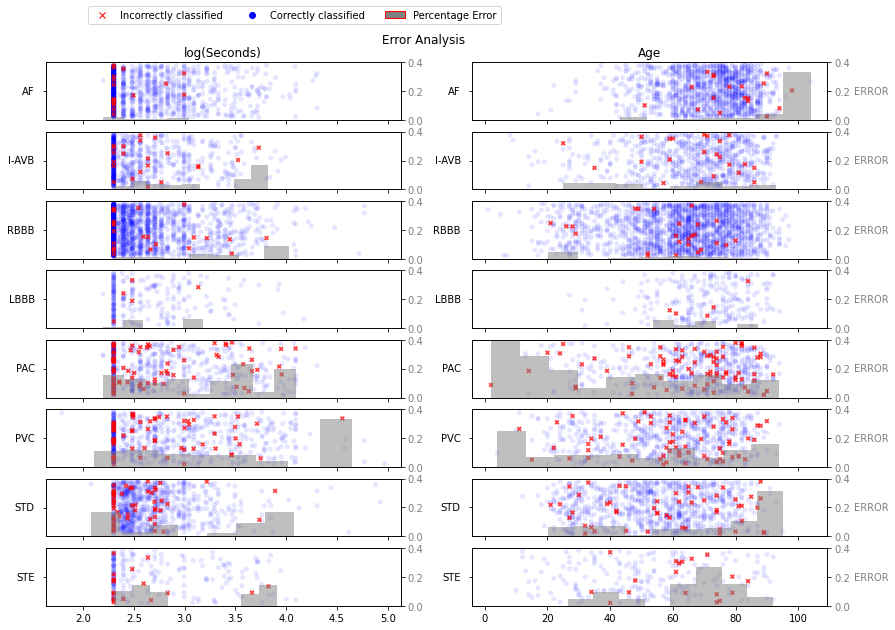

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
df["seconds"] = np.log(df.signal_len/df.freq)
fig, axs_all = plt.subplots(8, 2, figsize=(14,10), sharex="col")
axs = axs_all[:, 0]
for idx, c in enumerate(CLASSES):
    df_all = df[df["truth_" + c]]
    df_fp = df[df["truth_" + c] & (df["truth_" + c] != df["pred_" + c] )]
    df_tp = df[df["truth_" + c] & (df["truth_" + c] == df["pred_" + c] )]
    sns.stripplot(df_tp["seconds"] , ax=axs[idx], alpha=0.1, color="blue")
    sns.stripplot(df_fp["seconds"] , ax=axs[idx], alpha=0.75, color="red", marker="X")

    axs[idx].set_xlabel("")
    axs[idx].set_ylabel(c, rotation=0, ha="right", va='center')
    
    axs_ = axs[idx].twinx()
    bins_edges = np.histogram_bin_edges(df_all.seconds, bins=10)
    df_all["bin"] = pd.cut(df_all.seconds, bins=bins_edges, right=False)
    correct = df_all.groupby("bin")["pred_"+c].mean()
    for ids, row in zip(correct.index, correct):
        plt.plot()
        ids = [ids.left, ids.right]
        axs_.bar((ids[0] + ids[1])/2, 1-row, width=ids[1] - ids[0], color="gray", alpha=0.5)
        
    axs_.set_ylim([0,0.4])
    axs_.set_yticklabels(axs_.get_yticks(), color="gray")
    
axs = axs_all[:, 1]

for idx, c in enumerate(CLASSES):
    df_all = df[df["truth_" + c]]
    df_fp = df[df["truth_" + c] & (df["truth_" + c] != df["pred_" + c] )]
    df_tp = df[df["truth_" + c] & (df["truth_" + c] == df["pred_" + c] )]
    sns.stripplot(df_tp["age"] , ax=axs[idx], alpha=0.1, color="blue")
    sns.stripplot(df_fp["age"] , ax=axs[idx], alpha=0.75, color="red", marker="X")

    axs[idx].set_xlabel("")
    axs[idx].set_ylabel(c, rotation=0, ha="right", va='center')
    
    axs_ = axs[idx].twinx()
    bins_edges = np.histogram_bin_edges(df_all.age, bins=10)
    df_all["bin"] = pd.cut(df_all.age, bins=bins_edges, right=False)
    correct = df_all.groupby("bin")["pred_"+c].mean()
    for ids, row in zip(correct.index, correct):
        plt.plot()
        ids = [ids.left, ids.right]
        axs_.bar((ids[0] + ids[1])/2, 1-row, width=ids[1] - ids[0], color="gray", alpha=0.5)
        
    axs_.set_ylim([0,0.4])
    axs_.set_yticklabels(axs_.get_yticks(), color="gray")
    axs_.set_ylabel("ERROR", rotation = 0, ha="left", va="center", color="gray")
    
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fig.suptitle("Error Analysis", y=0.92)
axs_all[0, 1].set_title("Age")
axs_all[0, 0].set_title("log(Seconds)")
legend_elements = [ Line2D([0], [0], lw=0, marker='x', color='red', label='Incorrectly classified'),
                   Line2D([0], [0], lw=0, marker='o', color='blue', label='Correctly classified'),
                   Patch(facecolor='gray', edgecolor='r', label='Percentage Error')]

# Create the figure
axs_all[0, 1].legend(handles=legend_elements, ncol=3, bbox_to_anchor=(-.5, 2.05), loc='upper center')
plt.show()

fig.savefig("./error_analysis.pdf", bbox_inches='tight')

## Plots  ROC/Precision-Recall Curves

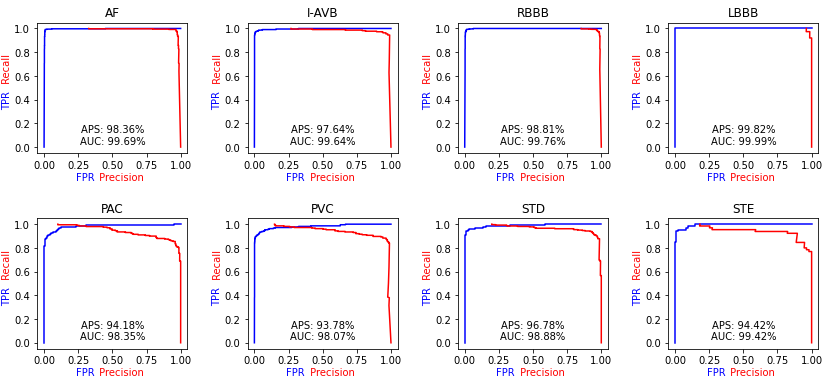

In [4]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
fig, axs_all = plt.subplots(2, 4, figsize=(14,6), gridspec_kw={"hspace":0.5, "wspace":0.4})
axs = axs_all.flatten()

df_ = df[df.valid]
for idx, c in enumerate(CLASSES):
    y, probs = df_["truth_{}".format(c)].values, df_["prob_{}".format(c)].values
    fpr, tpr, _ = roc_curve(y, probs)
    axs[idx].plot(fpr, tpr, "blue")
    fpr, tpr, _ = precision_recall_curve(y, probs)
    axs[idx].plot(fpr, tpr, color="red")
    multicolor_ylabel(axs[idx], ["TPR ", " Recall"], ["Red",  "Blue"], axis='y')
    multicolor_ylabel(axs[idx], ["FPR ", " Precision"], ["Blue",  "Red"], axis='x')

    auc = roc_auc_score(y, probs)
    aps = average_precision_score(y, probs)
    axs[idx].text(0.5, 0.025, "APS: {}%\nAUC: {}%".format(str(round(100*aps,2)), 
                                                          str(round(100*auc,2))), ha="center")
    axs[idx].set_title(c)
    
fig.savefig("./curves.pdf", bbox_inches='tight')

## Confusion matrix

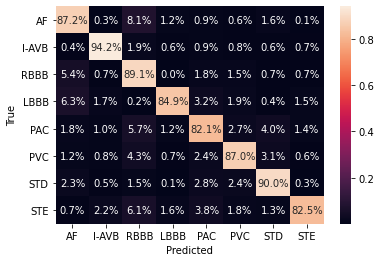

In [9]:
fig, axs_all = plt.subplots(1, figsize=(6,4))


df_adj = pd.DataFrame(0, columns=CLASSES, index=CLASSES)
for _, row in df.iterrows():
    true_classes = []
    pred_casses = []
    row = dict(row)
    for c in CLASSES:
        if row["pred_{}".format(c)]:
            pred_casses.append(c)
        if row["truth_{}".format(c)]:
            true_classes.append(c)                   
    for c1, c2 in itertools.product(true_classes, pred_casses):
        df_adj.loc[c1, c2] += 1/len(true_classes)
        df_adj.loc[c2, c1] += 1/len(true_classes)

df_adj = df_adj.apply(lambda x: x/x.sum(), axis=1)
sns.heatmap(df_adj, annot=True, fmt=".1%", ax=axs_all)
plt.ylabel("True")
plt.xlabel("Predicted")

fig.savefig("./confusion.pdf", bbox_inches='tight')

## Inspects class co-occurrence

In [ ]:
df_adj = pd.DataFrame(0, columns=CLASSES, index=CLASSES)
for _, row in df.iterrows():
    true_classes = []
    row = dict(row)
    for c in CLASSES:
        if row["truth_{}".format(c)]:
            true_classes.append(c)
    if len(true_classes) > 2:
        for c1, c2 in itertools.combinations(true_classes, 2):
            df_adj.loc[c1, c2] += 1/len(true_classes)
            df_adj.loc[c2, c1] += 1/len(true_classes)
print(df_adj.to_latex())

In [ ]:
df_adj = pd.DataFrame(0, columns=CLASSES, index=CLASSES)
for _, row in df.iterrows():
    true_classes = []
    row = dict(row)
    for c in CLASSES:
        if row["pred_{}".format(c)]:
            true_classes.append(c)
    if len(true_classes) > 2:
        for c1, c2 in itertools.combinations(true_classes, 2):
            df_adj.loc[c1, c2] += 1/len(true_classes)
            df_adj.loc[c2, c1] += 1/len(true_classes)
print(df_adj.to_latex())